# Notebook initialization

## Selecting best GPU to execute on

In [31]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import gpustat

stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), stats)
bestGPU = 0#min(zip(ids, ratios), key=lambda x: x[1])[0]

print("setGPU: Setting GPU to: {}".format(bestGPU))
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(bestGPU)

setGPU: Setting GPU to: 0


##  Global variables

In [32]:
# IPython extension to reload modules before executing user code.
# 'autoreload' reloads modules automatically before entering the execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, "../")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
with open('simulation_id.txt', 'r') as f:
    simulation_id = int(f.read())

#with open('simulation_id.txt', 'w') as f:
 #   f.write(str(simulation_id))

In [34]:
weights_path = lambda wid, name: '../weights/{}/{}/'.format(wid, name)
figures_path = lambda name: 'figures/{}/{}/'.format(simulation_id, name)

In [35]:
print(simulation_id)
import datetime
date = datetime.datetime.now()

3


## Seed initialization (for reproductible results)

In [36]:
# Setting the seed for NumPy generated random numbers
import numpy as np
np.random.seed(0)

# Setting the seed for Python random numbers
import random as rn
rn.seed(0)

# Setting the seed for TensorFlow random numbers
import tensorflow as tf
tf.set_random_seed(0)

#from keras.backend.tensorflow_backend import set_session
#config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.5
#set_session(tf.Session(config=config))

# Importing packages

## User defined packages

In [37]:
from data_utils import *
from keras_utils import plot_layerwise_angle_deviation_curves, LayerwiseAngleDeviationCurves, LearningRateMonitor, get_kernel_layer_names
from models import VGG16_Vanilla, VGG16, VGG16_Vanilla_beta, VGG16_beta

## Other packages

In [38]:
from keras import optimizers
from keras import callbacks
from keras.models import clone_model
from keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from collections import defaultdict
import scipy
import matplotlib.pyplot as plt
import pathlib
import pickle
from layca_optimizers import SGD

# Training model

In [39]:
num_classes = 10

In [40]:
(x_train, y_train), (x_test, y_test) = import_cifar(num_classes)

In [41]:
model_names = ['vgg16_vanilla_layca_bad']
models = {
    'vgg16_vanilla_layca_bad': VGG16_Vanilla_beta(input_shape=(32,32,3), num_classes=num_classes)
} 

In [42]:
for name, model in models.items():
    pathlib.Path(weights_path(simulation_id, name) + 'initial/').mkdir(parents=True, exist_ok=True) 
    pathlib.Path(weights_path(simulation_id, name) + 'final/').mkdir(parents=True, exist_ok=True) 
    pathlib.Path(weights_path(simulation_id, name) + 'byepoch/').mkdir(parents=True, exist_ok=True) 
    pathlib.Path(figures_path(name)).mkdir(parents=True, exist_ok=True)

In [43]:
for name, model in models.items():
    model.save_weights(weights_path(simulation_id, name) + 'initial/weights-initial.hdf5')

In [25]:
def train(model_name, lr, epochs, batch_size, validation_split, momentum, layca):  
       
    with open(weights_path(simulation_id, model_name) + 'parameters.pickle', 'wb') as handle:
        pickle.dump({'date': date,
                     'lr': lr, 
                     'epochs': epochs,
                     'batch_size': batch_size,
                     'validation_split': validation_split,
                     'momentum': momentum
                    }, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    model = models[model_name]
    
    ladc = LayerwiseAngleDeviationCurves()
    callbacks = [ladc]
    callbacks += [ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_delta=1e-7)]
    callbacks += [LearningRateMonitor()]
    callbacks += [ModelCheckpoint(weights_path(simulation_id, model_name) + 'byepoch/weights-{epoch:02d}.hdf5', save_weights_only=True)]
    
    # Optimization details
    sgd = SGD(lr=lr, momentum=momentum, nesterov=True, layca=layca)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    hist = model.fit(x=x_train, 
                     y=y_train,
                     validation_split=validation_split,
                     batch_size=batch_size, 
                     epochs=epochs, 
                     verbose=1, 
                     callbacks=callbacks)
    
    with open(weights_path(simulation_id, model_name) + 'history.pickle', 'wb') as handle:
        pickle.dump(hist.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return ladc

In [44]:
ladc_list = list()
ladc_list.append(train(model_name='vgg16_vanilla_layca_bad', lr=0.0008, epochs=50, batch_size=256, validation_split=0.2, momentum=0.9, layca=True))

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 16s 395us/step - loss: 1.5937 - acc: 0.4476 - val_loss: 1.4839 - val_acc: 0.4949
current learning rate: 0.0007999999797903001
Epoch 2/50
  768/40000 [..............................] - ETA: 17s - loss: 1.1879 - acc: 0.6237

/linux/mnovak/penv/lib/python3.5/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101054). Check your callbacks.
  % delta_t_median)


40000/40000 [==============================] - 14s 354us/step - loss: 1.1445 - acc: 0.6422 - val_loss: 1.2438 - val_acc: 0.5950
current learning rate: 0.0007999999797903001
Epoch 3/50
40000/40000 [==============================] - 14s 354us/step - loss: 0.8974 - acc: 0.7558 - val_loss: 1.2264 - val_acc: 0.6372
current learning rate: 0.0007999999797903001
Epoch 4/50
40000/40000 [==============================] - 14s 357us/step - loss: 0.6796 - acc: 0.8572 - val_loss: 1.2395 - val_acc: 0.6317
current learning rate: 0.0007999999797903001
Epoch 5/50
40000/40000 [==============================] - 14s 359us/step - loss: 0.5167 - acc: 0.9299 - val_loss: 1.2016 - val_acc: 0.6426
current learning rate: 0.0007999999797903001
Epoch 6/50
40000/40000 [==============================] - 14s 359us/step - loss: 0.4216 - acc: 0.9643 - val_loss: 1.1589 - val_acc: 0.6612
current learning rate: 0.0007999999797903001
Epoch 7/50
40000/40000 [==============================] - 14s 360us/step - loss: 0.3861 - a

/linux/mnovak/penv/lib/python3.5/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105794). Check your callbacks.
  % delta_t_median)


40000/40000 [==============================] - 14s 361us/step - loss: 0.2925 - acc: 0.9998 - val_loss: 1.0702 - val_acc: 0.7081
current learning rate: 3.199999991920777e-05
Epoch 36/50
40000/40000 [==============================] - 14s 362us/step - loss: 0.2917 - acc: 0.9998 - val_loss: 1.0738 - val_acc: 0.7086
current learning rate: 3.199999991920777e-05
Epoch 37/50
40000/40000 [==============================] - 14s 358us/step - loss: 0.2925 - acc: 0.9998 - val_loss: 1.0690 - val_acc: 0.7098
current learning rate: 3.199999991920777e-05
Epoch 38/50
40000/40000 [==============================] - 14s 360us/step - loss: 0.2931 - acc: 0.9998 - val_loss: 1.0716 - val_acc: 0.7114
current learning rate: 3.199999991920777e-05
Epoch 39/50
40000/40000 [==============================] - 14s 362us/step - loss: 0.2927 - acc: 0.9999 - val_loss: 1.0703 - val_acc: 0.7096
current learning rate: 3.199999991920777e-05
Epoch 40/50
40000/40000 [==============================] - 14s 359us/step - loss: 0.291

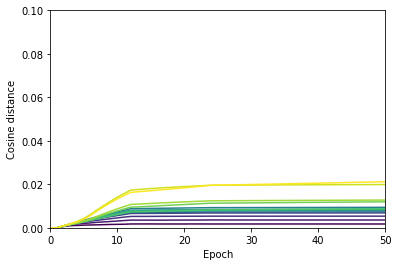

In [46]:
for name, ladc in zip(model_names, ladc_list):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    plot_layerwise_angle_deviation_curves(ladc.memory, ax)
    fig.savefig(figures_path(name) + 'cosine_dist.png', dpi=100)

In [47]:
for wid, name, model in models.items():
    model.save_weights(weights_path(name) + 'final/weights-final.hdf5')

TypeError: <lambda>() missing 1 required positional argument: 'name'

## Evaluation

In [ ]:
# Simply loading both the initial and finals weights of our models

models = [
    (3, 'vgg16_vanilla_layca_bad', VGG16_Vanilla_beta(input_shape=(32,32,3), num_classes=10)),
    (1, 'vgg16_vanilla_beta', VGG16_Vanilla_beta(input_shape=(32,32,3), num_classes=10)),
    (1, 'vgg16_beta', VGG16_beta(input_shape=(32,32,3), num_classes=10, weight_decay=0.005)),
    (1, 'vgg16_vanilla_layca', VGG16_Vanilla_beta(input_shape=(32,32,3), num_classes=10))
]

layer_names = [name.split('_', 1)[0] for name in get_kernel_layer_names(models[0][2])]
n_layers = len(get_kernel_layer_names(models[0][2]))

In [ ]:
for wid, name, model in models:
    model.load_weights(weights_path(wid, name) + 'final/weights-final.hdf5') 

In [ ]:
for wid, name, model in models:
    sgd = SGD(lr=0.001, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    scores = model.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])

## Parameters of the model